# Проект: вариант 1
Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:

В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.
Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.
Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm, mannwhitneyu, shapiro, levene
import matplotlib.pyplot as plt

from tqdm.auto import tqdm


import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime, date, time

import warnings
warnings.filterwarnings('ignore')

# Задание 1
Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).

Загрузим данные преобразовав колонку с датой в тип даты

In [2]:
reg_data = pd.read_csv('C:/Users/zhare/carpov/analyst/data/problem1-reg_data.csv', sep=';')
reg_data.reg_ts = pd.to_datetime(reg_data.reg_ts, unit='s').dt.date

auth_data = pd.read_csv('C:/Users/zhare/carpov/analyst/data/problem1-auth_data.csv', sep=';')
auth_data.auth_ts = pd.to_datetime(auth_data.auth_ts, unit='s').dt.date

# Проверка данных на корректность

Проверим есть ли пропуски в данных о регистрации

In [3]:
reg_data.isna().sum()

reg_ts    0
uid       0
dtype: int64

Проверим есть ли пропуски в данных о действиях пользователей

In [4]:
auth_data.isna().sum()

auth_ts    0
uid        0
dtype: int64

Проверим все ли пользователи уникальны

In [5]:
reg_data.uid.nunique() == reg_data.shape[0]

True

Информация о всех пользователях есть в таблице с действиями

In [6]:
reg_data.uid.nunique() == auth_data.uid.nunique()

True

Посмотрим на "крайние" даты в обеих таблицах

In [7]:
print('Данные о регистрации: ', reg_data.reg_ts.min(), '-',  reg_data.reg_ts.max())
print('Данные о действиях: ', auth_data.auth_ts.min(), '-',  auth_data.auth_ts.max())

Данные о регистрации:  1998-11-18 - 2020-09-23
Данные о действиях:  1998-11-18 - 2020-09-23


# Функция

Очевидно, что чаще всего на практике данная функция (cohort_retention) не будет использоваться для вычисления retention по всем историческим данным, а будет вызываться на интересующих нас временных интервалах. Также необходимо учесть тот факт, что классический вывод таблицы в pandas является сложно воспринимаемым, поэтому добавим возможность визуализировать результаты посредством построения тепловой карты (heatmap), наглядно показывающей динамику каждой когорты, и обычный график (lineplot), отражающий в целом динамику показателя (средневзвешенный retention). Для этого необходимы следующие входные параметры:
<ul>
<li>reg_data - данные о регистрации пользователей</li>
<li>auth_data - данные о действиях пользователей</li>
<li>start_date - дата начала формирования когорт</li>
<li>end_date - дата окончания формирования когорт</li>
<li>heatmap - визуализация поведения когорт</li>
<li>dynamics - визуализация изменения retention в целом</li>
</ul>
В силу очевидности состояния 0 дня, отсчет будет отображаться со дня следующего за днем регистрации.

Также для корректной работы функции необходимо создать функцию преобразования даты (preproсesing_date) из строки в тип date, для корректного изъятия необходимых данных из исходных файлов

In [8]:
def preproсesing_date(date):
    year = int(date[:4])
    month = int(date[5:7])
    day = int(date[-2:])
    return year, month, day

In [9]:
def cohort_retention(reg_data, auth_data, start_date, end_date, heatmap=True, dynamics=True):
    """
    reg_data - данные о дате регистрации пользователей
    auth_data - данные о действиях пользователей
    start_date - дата, с которой начинают формироваться когорты
    end_date - дата, на которой заканчиваются формироваться когорты
    heatmap - параметр, отвечающий за построение heatmap (по умолчанию строим)
    dynamics - параметр, отвечающий за построение динамики изменения retention во времени
    """
    # приводим входные строки с датами в формат дат
    year, month, day = preproсesing_date(start_date)
    start_date = date(year, month, day)
    year, month, day = preproсesing_date(end_date)
    end_date = date(year, month, day)
    # отбираем пользователей, зарегистрировавшихся в интересующем нас промежутке
    sample_reg_data = reg_data.query("reg_ts >= @start_date and reg_ts <= @end_date")
    sample_uid = sample_reg_data.uid
    sample_auth_data = auth_data.query('uid in @sample_uid')

    full_data = sample_auth_data.merge(sample_reg_data, on='uid', how='left')
    full_data['days'] = full_data['auth_ts'] - full_data['reg_ts']

    # активные пользователи
    cohorts = full_data \
                .groupby(['reg_ts','days'], as_index=False) \
                .aggregate({'uid':'nunique'}) \
                .rename(columns={'uid':'active_users',
                                 'reg_ts':'cohorts'})

    # приводим дни к int
    cohorts.days = cohorts.days.dt.days

    # отбираем сформировавшиеся когорты
    reg_users = cohorts[cohorts['days'] == 0]
    reg_users = reg_users[['cohorts','active_users']] \
                .rename(columns={'active_users':'cohort_users'})

    cohorts = cohorts.merge(reg_users, on='cohorts')
    # считаем retention
    cohorts['retention'] = round(100 * cohorts['active_users'] / cohorts['cohort_users'], 2)
    retention = cohorts.pivot_table(index='cohorts',
                                    columns='days',
                                    values='retention')
    
    # Блок визуализацтй
    if heatmap:
        plt.figure(figsize=[20, 12])
        plt.title('Retention Rate Detailed By Cohort')
        sns.heatmap(retention[range(1, len(retention.columns))], 
                    annot=True, cmap="Blues", square=True, linewidth=0.01, linecolor="#222")
        
    if dynamics:
        days = cohorts.days.unique()
        weight_average = []

        for day in days:
            weight_average.append(np.average(cohorts.query('days == @day').retention,
                                  weights=cohorts.query('days == @day').active_users))
            
        plt.figure(figsize=[16, 8])
        plt.title('Dynamics Weighted Average Retention Rate From The First Day')
        plt.xlabel('Days')
        plt.ylabel('Retention Rate')
        plt.grid()
        plt.plot(range(1, len(weight_average)), weight_average[1:])
        
    return retention

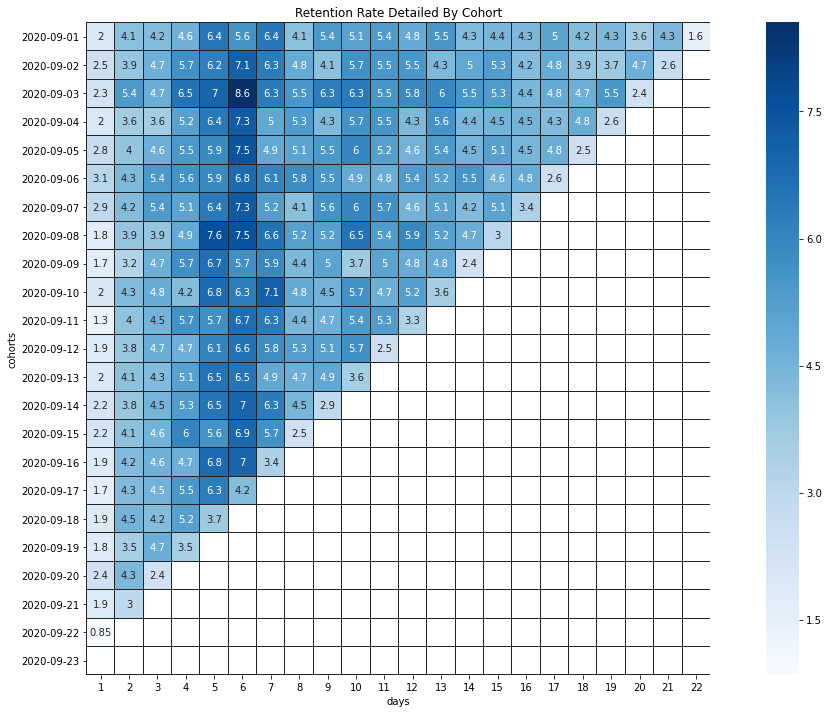

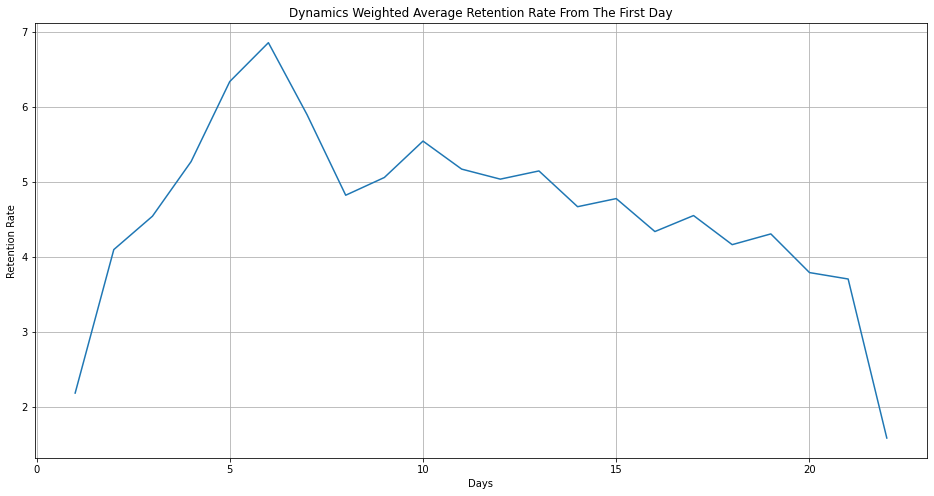

In [10]:
retention = cohort_retention(reg_data, 
                             auth_data,
                             start_date='2020-09-01',
                             end_date='2020-09-23',
                             heatmap=True,
                             dynamics=True)

# Задание 2
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

Загрузим данные

In [11]:
log_data = pd.read_csv('C:/Users/zhare/carpov/analyst/data/Проект_1_Задание_2.csv', sep=';')
log_data.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


## Разведовательный анализ данных

In [12]:
log_data.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [13]:
log_data.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

Посмотрим на основные статистические метрики

In [14]:
log_data \
    .groupby('testgroup') \
    .describe()['revenue']

,count,mean,std,min,25%,50%,75%,max
testgroup,,,,,,,,
a,202103.0,25.413720,920.768137,0.0,0.0,0.0,0.0,37433.0
b,202667.0,26.751287,287.324162,0.0,0.0,0.0,0.0,4000.0


В логах информация только об уникальных пользователях

In [15]:
log_data.user_id.nunique() == log_data.shape[0]

True

Выделим контрольную и тестовую группу, и две группы только платящих пользователей

In [16]:
group_a = log_data.query("testgroup == 'a'")
group_b = log_data.query("testgroup == 'b'")

group_a_pay = group_a.query('revenue > 0')
group_b_pay = group_b.query('revenue > 0')

<AxesSubplot:>

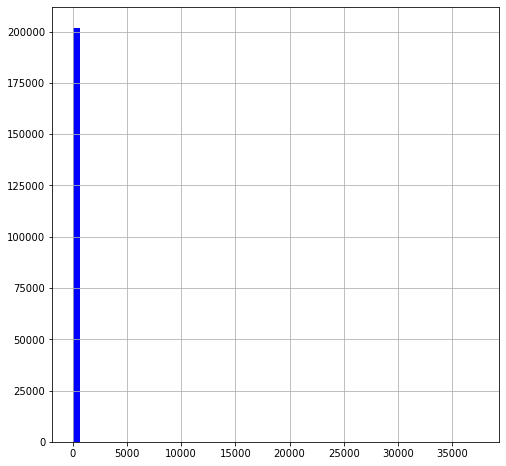

In [17]:
plt.figure(figsize=[8, 8])
group_a.revenue.hist(bins=60, color='blue')

<AxesSubplot:>

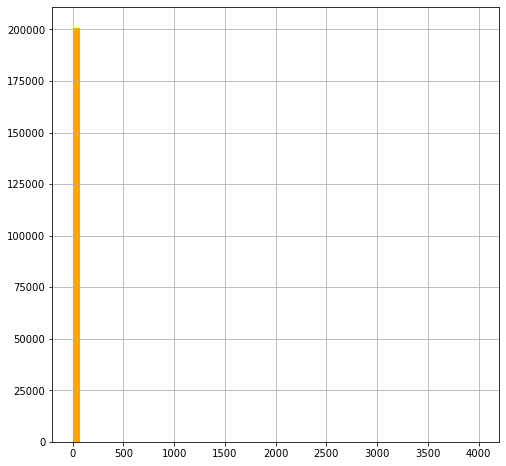

In [18]:
plt.figure(figsize=[8, 8])
group_b.revenue.hist(bins=60, color='orange')

Из анализа основных статистических метрик и гистограмм, можно сделать следующие первичные выводы
<ul>
<li>Подавляющая часть пользователей не совершала покупок</li>
<li>Максимальная сумма покупок значительно различается: для контрольной группы максимум - 37433.0, для тестовой - 4000.0)</li>
</ul>

## Тесты

Рассмотрим распределение трат у платящих пользователей

<AxesSubplot:>

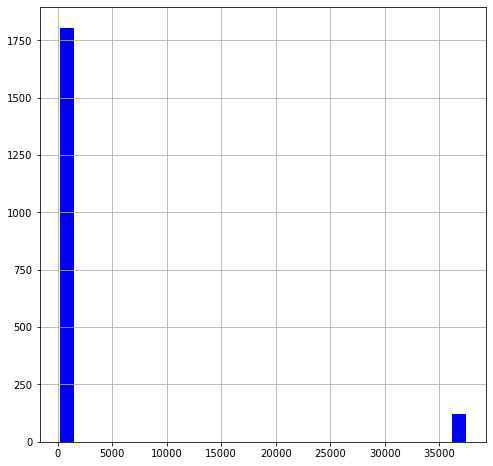

In [19]:
plt.figure(figsize=[8, 8])
group_a_pay.revenue.hist(bins=30, color='blue')

<AxesSubplot:>

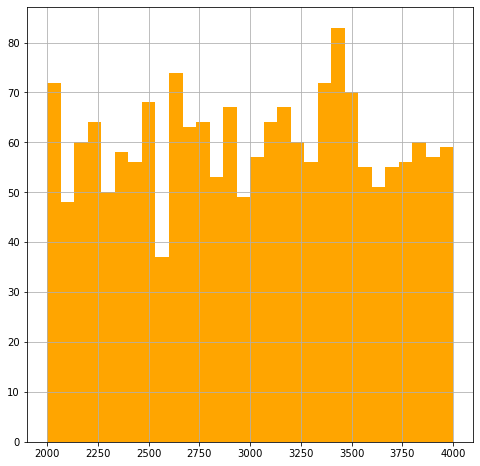

In [20]:
plt.figure(figsize=[8, 8])
group_b_pay.revenue.hist(bins=30, color='orange')

Сконцентрируемся на денежных метриках, рассмотрев только плативших пользователей. Поскольку невооруженным взглядом видно, что распределения ненормальны будем использовать bootstrap, но перед этим для формальности проведем тест Шапиро-Уилка для проверки нормальности распределений

In [21]:
print('Shapiro (A) p-value', shapiro(group_a_pay.revenue)[1])
print('Shapiro (B) p-value', shapiro(group_b_pay.revenue)[1])

Shapiro (A) p-value 0.0
Shapiro (B) p-value 2.491345674771425e-22


Вывод: 
<ul>
<li>Распределения отличны от нормального</li>
</ul>

В качестве метода выберем бустрап и будем проверять средние значения выборок, содержащих информацию только о тративших деньги пользователях, на уровне значимости 0.05

In [22]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.figure(figsize=[8, 8])
    plt.hist(pd_boot_data[0], bins = 50)
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

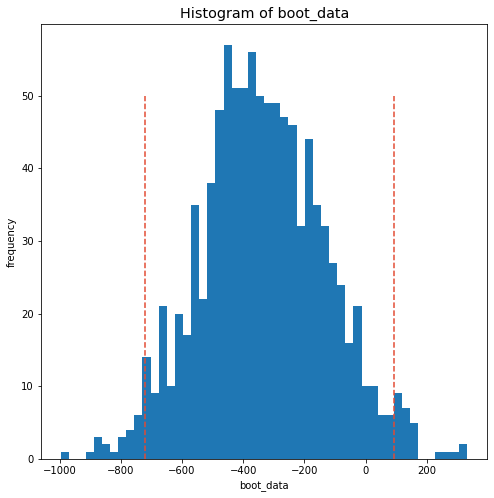

p-value = 0.10088387383322002


In [23]:
booted_data = get_bootstrap(group_a_pay.revenue, group_b_pay.revenue, boot_it = 1000)
print('p-value =', booted_data['p_value'])

## Анализ метрик

Полученные результаты не позволяют нам отвергнуть H0 о равенстве средних в группах платящих пользователей.
Но анализируя гистограммы платящих пользователей очевидно, что решающий вклад вносит хвост контрольного (синего) распределения. Посмотрим какой вклад он вносит в общую картину

In [24]:
revenue_a_95 = int(np.percentile(group_a_pay.revenue, q=95))
group_a_pay.query('revenue >= @revenue_a_95').revenue.sum() / group_a_pay.revenue.sum()

0.7339574147290919

Всего 5% пользователей приносят 73% выручки, учтем это при финальном выводе

Для более глубокого анализа эксперимента посмотрим на ряд метрик (CR, ARPU, ARPPU, revenue), чтобы избежать ситуации, когда по одному из критериев оценки изменения оказываются позитивными, а по другим важным для бизнеса показателям на тестовой выборке видна "просадка".

In [25]:
cr_a = group_a_pay.shape[0] / group_a.shape[0] * 100
cr_b = group_b_pay.shape[0] / group_b.shape[0] * 100

revenue_a = group_a.revenue.sum()
revenue_b = group_b.revenue.sum()

arpu_a = revenue_a / group_a.shape[0]
arpu_b = revenue_b / group_b.shape[0]

arppu_a = revenue_a / group_a.query('revenue > 0').shape[0]
arppu_b = revenue_b / group_b.query('revenue > 0').shape[0]

print('Конверсия контрольной группы - ', cr_a)
print('Конверсия тестовой группы - ', cr_b)
print('Конверсия в тестовой группе уменьшилась на ', round(cr_a - cr_b, 2), 'п. п. \n')

print('Доход в контрольной группы - ', revenue_a)
print('Доход в тестовой группы - ', revenue_b)
print('Доход в тестовой группе увеличился на', round((revenue_b - revenue_a)*100 / revenue_b, 1), '%\n')

print('ARPU контрольной группы - ', arpu_a)
print('ARPU тестовой группы - ', arpu_b)
print('ARPU в тестовой группе увеличился на', round((arpu_b - arpu_a)*100 / arpu_a, 1), '%\n')

print('ARPPU контрольной группы - ', arppu_a)
print('ARPPU тестовой группы - ', arppu_b)
print('ARPPU в тестовой группе увеличился на', round((arppu_b - arppu_a)*100 / arppu_b, 1), '%\n')

Конверсия контрольной группы -  0.9539690157988748
Конверсия тестовой группы -  0.8906235351586593
Конверсия в тестовой группе уменьшилась на  0.06 п. п. 

Доход в контрольной группы -  5136189
Доход в тестовой группы -  5421603
Доход в тестовой группе увеличился на 5.3 %

ARPU контрольной группы -  25.413719736965806
ARPU тестовой группы -  26.75128659327863
ARPU в тестовой группе увеличился на 5.3 %

ARPPU контрольной группы -  2663.9984439834025
ARPPU тестовой группы -  3003.6581717451522
ARPPU в тестовой группе увеличился на 11.3 %



# Вывод
Для вынесения итогового решения будем руководствоваться не только результатами проведения бутстрапа и полученным p-value, но и практической значимостью. Резюмируем все сделанное:
<ul>
<li>Распределения трат у платящих пользователей различаются по своей структуре: распределение контрольной группы скошено влево и имеет хвост, вносящий сильный вклад в итоговое среднее значение; распределение тестовой группы имеет форму схожую с равномерным и зажато в более узком диапазоне [2000; 4000]. <strong>Из этого можно сделать вывод о том, что эксперимент оказал влияние на поведение пользователей;</strong></li>
<li>Результат бутстрапа не позволил отвергнуть H0 о равенстве средних у платящих пользователей;</li>
<li>Анализ плативших пользователей в контрольной группе показал, что 73% от всего дохода приносят лишь 5% пользователей;</li>
<li>Анализ других метрик показал <strong>снижение конверсии для тестовой группы на 0.06 п.п. увеличение revenue и ARPU на 5% и ARPPU на 11%.</strong></li>
</ul>
Таким образом, если речь идет о безальтернативном решении, я бы предложил выкатить тестовую версию, поскольку здесь мы имеем бОльшую стабильность и предсказуемость (равномерность) в тратах пользователей, исходя из чего можем осуществлять более надежное планирование и прогнозирование; также учитывая факт повышения других денежных метрик. 
<strong>Однако, наиболее рациональным выглядит вариант оставить тратящим много (> 35 000) старую систему предложений, а остальным, тратящим мало выкатить новую систему.</strong>


А также необходимо проработать вопрос уменьшения конверсии

# Задание 3
В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?



## Метрики

В качестве основных метрик можно предложить:
<ul>
<li>ASL - средняя продолжительность сессии;</li>
<li>Retention rate - коэффициент удержания. Как пользователи возвращаются в наше мероприятие;</li>
<li>ARPU - средний доход с одного пользователя; Проигрывая, пользователи могут донатить и покупать жизни</li>
<li>Число пользователей успешно, завершивших мероприятие / число участвовавших. Для отслеживания сложности уровней;</li>
<li>Общая полученная награда за мероприятие - выраженная в реальных деньгах. Важно контролировать это значение, поскольку в случае получения большой награды, пользователь может пересать донатить некоторое время.</li>
</ul>
После обновления, можно добавить следующую метрику:
<ul>
<li>Среднее число уровней пройденных подряд успешно / число уровней в мероприятии. Для регулирования сложности.</li>
</ul>